# _*Repetition code for up to 15 qubits*_

***
### Contributors
James R. Wootton, University of Basel
***

## 1 - Introduction

The repetition code is a classical error correcting code, with which a collection of noisy bits can be used to store a bit value with arbitrarily low noise.

The code can also be interpreted as a quantum error correcting code, in which the noisy bits are replaced by noisy qubits. Such a code can be used to store a *bit* with arbitrarily low noise. However, due to the limited set of errors that can be detected and corrected, it cannot fully protect a *qubit*.

Despite this fact, the repetition code based on qubits uses essentially the same resources and techniques as other quantum codes. It can therefore serve as a prelimary test of quantum error correction. An introduction to these concepts for a general audience can be found [here](http://decodoku.blogspot.ch/2016/01/what-is-error-correction-what-is.html).

Until now, the most extensive experiments of quantum repetition codes were implemented a few years ago by the team at Google/UCSB.

[J. Kelly et al., Nature **519**, *66–69* (2015)](https://www.nature.com/nature/journal/v519/n7541/full/nature14270.html)

The largest repetition code in this experiment used 5 qubits to store data (we call these *code qubits*), and an additional 4 *ancilla qubits* to mediate measurements. In this notebook we will use the 16 qubit device to implement codes of a variety of sizes, including some larger than those in the Google/UCSB experiment.

The number of code qubits in our experiments will be denoted *d*. The number of ancilla qubits in a repetition code is always *d-1*, one less than that of code qubits.

We will also use an additional qubit that is not part of the code, to compare storing a bit in a code with storing it in a single qubit. The total number of qubits needed is therefore *2d*. We will consider codes for *d=3...8*.

In each case we will do a single round of ancilla-assisted syndrome measurement followed by direct measurement of all qubits. This allows us to read out the value of the stored bit, as well as clues about errors that it may have suffered. Using this information, we can try to correct for the effects of the errors and recover the original value of the stored bit. By looking at how often this process succeeds, we will be able to see how well the system implements quantum error correction.

The conditions under which we will declare the system as able to successfully implement the repetion code will be those set out in,

[J. R. Wootton, A. Peter, J. R. Winkler, D. Loss, Phys. Rev. A **96**, 032338 (2017)](https://arxiv.org/abs/1608.05053).

The aim of this study is to look at the properties of the repetion code when run using the 16 qubit device, and compare them to simulated runs (with artificial noise). The outputs currently in this notebook come from analysis of results from the device when it was designated *ibmqx3*, the data for which can be found [here](https://github.com/decodoku/repetition_code). Further results for the current incarnation of the device, designated *ibmqx5*, can also be found there. The results have been used as the basis for the following paper.

[J. R. Wootton, D. Loss, arXiv:1709.00990 (2017)](https://arxiv.org/abs/1709.00990).

This contains additional commentary on the presented graphs in this notebook.

In the program, the qubits in the register are labelled according to their address on the chip. The information can be found [here](https://github.com/IBM/qiskit-qx-info/tree/master/backends/ibmqx5).

    1---2---3---4---5===6---7---8
    |   ║   |   |   |   |   |   |
    0--15--14--13--12--11--10---9

Lines in this diagram denote the possibility of a CNOT between the corresponding qubits. The CNOTs denoted by double lines were not able to be used in *ibmqx3*, but can be used presently.

Qubits in the repetition code alternate between code and ancilla qubits. The single qubit is placed at the end of the line. For the case of d=8, the layout of these qubits will be as follows.

    c2--a1--c1--a0--c0===s--c7--a6
     |   ║   |   |   |   |   |   |
    a2--c3--a3--c4--a4--c5--a5--c6
 
The address of code qubit c$n$ therefore $(5-2n)$%$16$.

The address of ancilla qubit a$n$ is $(4-2n)$%$16$.

***

## 2 - Set Up

First we set up things required to run things using QISKit, and on the Quantum Experience.

Set up intructions can be found in the [IBM SDK](https://github.com/QISKit/qiskit-sdk-py/).

For more information about how to use the IBM Quantum experience, check out the [tutorials](https://quantumexperience.ng.bluemix.net/qstage/#/tutorial?sectionId=c59b3710b928891a1420190148a72cce&pageIndex=0), and the [community](https://quantumexperience.ng.bluemix.net/qstage/#/community).

In [1]:
from qiskit import ClassicalRegister, QuantumRegister
from qiskit import QuantumCircuit, execute
from qiskit import register, available_backends, get_backend

#import Qconfig and set APIToken and API url
import sys
sys.path.append("../") # go to parent dir
import Qconfig
qx_config = {
    "APItoken": Qconfig.APItoken,
    "url": Qconfig.config['url']}

#set api
register(qx_config['APItoken'], qx_config['url'])

Next we import a few standard things.

In [2]:
import math, scipy, copy, time
import numpy as np

***
## 3 - Functions

The running of jobs and processing of data is handled by the following functions.

### *AddDelay*

To increase the effects of errors, a delay can be added on all qubits. This delay is made up of a number of identity gates specified on *delay*. These are applied to all qubits, so the qubit number *num* must be provided also.

In [3]:
def AddDelay (script,q,num,delay):
    
    for _ in range(delay):
        for address in range(num):
            script.iden(q[address])

### *AddCnot*

The input specifies control and target qubits for a CNOT gate.

The function implements the CNOT if it is allowed by the device used. If the CNOT is not directly possible, but one with control and target interchanged can be done, conjugation by Hadamards is performed. Otherwise it will print an error.

For a simulator, all things are possible.

In [4]:
def  AddCnot(script,q,control,target,device):
    
    # set the coupling map
    # b in coupling_map[a] means a CNOT with control qubit a and target qubit b can be implemented
    # this is essentially just copy and pasted from
    #     https://github.com/IBM/qiskit-qx-info/tree/master/backends/ibmqx3
    #     https://github.com/IBM/qiskit-qx-info/tree/master/backends/ibmqx5
    # but with a few stylistic changes
    coupling_map = {}
    coupling_map['ibmqx3'] = {0: [1], 1: [2], 2: [3], 3: [14], 4: [3, 5], 5: [], 6: [7, 11], 7: [10],
                              8: [7], 9: [10, 8], 10:[], 11: [10], 12: [5, 11, 13], 13: [4, 14], 14:[], 15: [0, 14]}
    coupling_map['ibmqx5'] = {0:[],1:[0,2], 2:[3], 3:[4, 14], 4:[], 5:[4], 6:[5,7,11], 7:[10],
                              8:[7], 9:[8, 10], 10:[], 11:[10], 12:[5, 11, 13], 13:[4, 14], 14:[], 15:[0, 2, 14]}
        
    simulator = (device not in ['ibmqx3','ibmqx5'])
    
    # if simulator, just do the CNOT
    if simulator:
        script.cx(q[control], q[target])
    # same if the coupling map allows it
    elif target in coupling_map[device][control]:
        script.cx(q[control], q[target])
    # if it can be done the other way round we conjugate with Hadamards
    elif ( control in coupling_map[device][target] ):
        script.h(q[control])
        script.h(q[target])
        script.cx(q[target], q[control])
        script.h(q[control])
        script.h(q[target])
    else:
        print('Qubits ' + str(control) + ' and ' + str(target) + ' cannot be entangled.')

### *GetAddress*

Given a code qubit specified by input *codeQubit* this function gives the address of that qubit in the register. For the ancillas either side, use an offset of *+1* or *-1*.

For *codeQubit=0* only *offset=1* gives a valid ancilla. For *codeQubit=d-1* (the last one) *offset=-1* gives the last ancilla and *offset=1* gives the qubit that is trying to store the bit value on its own.

For a simulator we don't bother with the coupling graph, so things are different and simpler.

In [5]:
def GetAddress (codeQubit,offset,simulator):
    
    if (simulator):
        address = 2*codeQubit + offset
    else:
        address = (5-2*codeQubit-offset)%16
    
    return address

### *RunRepetition*

This function takes a specification for a repetition code, runs it and then returns the result.

Inputs:

* *bit* - Bit value to be stored in the repetition code. If it is not *1*, it will be treated as *0*.
    
* *d* - Number of code qubits

* *device* - The backend device on which the job will be run. This should be 'ibmqx3', 'local_qasm_simulator' or 'ibmqx_qasm_simulator'.
* *delay* - Integer number of delays to use between rounds of CNOTs.

Output:

* *results* - Dictionary with bit strings as keys and the fraction of times that result occurred as values.

In [6]:
def RunRepetition(bit,d,device,delay,totalRuns):
    
    # set the number of shots to use on the backend
    shots = 8192
    
    # determine whether a simulator is used
    simulator = (device not in ['ibmqx3','ibmqx5'])
    
    # if the simulator is used, we declare the minimum number of qubits required
    if (simulator):
        num = 2*d
    # for the real device there are always 16
    else:
        num = 16
          
    repetitionScript = [] # we create a batch job of totalRuns identical runs
    for run in range(totalRuns):
        
        # set up registers and program
        q = QuantumRegister(num)
        c = ClassicalRegister(num)
        repetitionScript.append( QuantumCircuit(q, c) )

        # now we insert all the quantum gates to be applied
        # a barrier is inserted between each section of the code to prevent the complilation doing things we don't want it to

        # the stored bit is initialized by repeating it across all code qubits same state
        # since qubits are automatically initialized as 0, we just need to do Xs if b=1
        if (bit==1):
            for codeQubit in range(d):
                repetitionScript[run].x( q[GetAddress(codeQubit,0,simulator)] )
            # also do it for the single qubit on the end for comparision
            repetitionScript[run].x( q[GetAddress(d-1,1,simulator)] )

        repetitionScript[run].barrier()

        # if the code is simulated add rotations for error like effects (and a barrier)
        AddDelay(repetitionScript[run],q,num,delay)

        # we then start the syndrome measurements by doing CNOTs between each code qubit and the next ancilla along the line
        for codeQubit in range(d-1):
            AddCnot(repetitionScript[run],q,GetAddress(codeQubit,0,simulator),GetAddress(codeQubit,1,simulator),device)

        repetitionScript[run].barrier()

        # if the code is simulated add rotations for error like effects (and a barrier)
        AddDelay(repetitionScript[run],q,num,delay)

        # next we perform CNOTs between each code qubit and the previous ancilla along the line
        for codeQubit in range(1,d):
            AddCnot(repetitionScript[run],q,GetAddress(codeQubit,0,simulator),GetAddress(codeQubit,-1,simulator),device)

        repetitionScript[run].barrier()

        # if the code is simulated add rotations for error like effects (and a barrier)
        AddDelay(repetitionScript[run],q,num,delay)

        # all qubits are then measured
        for address in range(num):
            repetitionScript[run].measure(q[address], c[address])

        # noise is turned on if simulator is used
        #repetitionScript[run].noise(int(simulator))
            
    # run the job (if the device is available)
    backends = available_backends()
    backend = get_backend(device)
    print('Status of '+device+':',backend.status)

    dataNeeded = True
    while dataNeeded==True:
        if backend.status["available"] is True:
            print("\nThe device is available, so the following job is being submitted.\n")

            print(repetitionScript[1].qasm())
            
            shots_device = 1000
            job = execute(repetitionScript, backend, shots=shots, skip_translation=True)
            
            results = []
            for run in range(totalRuns):
                results.append( job.result().get_counts(repetitionScript[run]) )
            
            dataNeeded = False
        else:
            print("\nThe device is not available, so we will wait for a while.")
            time.sleep(600)
    
    # the raw data states the number of runs for which each outcome occurred
    # we convert this to fractions before output.
    for run in range(totalRuns):
        for key in results[run].keys():
            results[run][key] = results[run][key]/shots
    
    # return the results
    return results

### *AddProbToResults*

The inputs are a probability *prob* for a given bit string *string* that is to be added to a dictionary *results*. The probability is added to the previous value for that bit string if it exists.

In [7]:
def AddProbToResults(prob,string,results):
    
    if string not in results.keys():
        results[string] = 0
    
    results[string] += prob

### *CalculateError*

The job of this function is to determine the total probability that the decoding fails when the encoded bit value is that specified by the input *encodedBit*. The way in which this is done is depends on the decoding procedure, which we will now explain.

The decoder uses a lookup table, given by the input *table*. This is a pair of dictionaries, one for each possible value of the encoded bit, with bit strings as keys and probabilties of the form

$$table[encodedBit][string] = P(\,string\,|\,encodedBit\,).$$

Suppose the decoder were to receive an output *string* from a single run of the code with unknown initial value. The goal is then to deduce the most likely value of the encoded bit. This can be done using

$$P(\,encodedBit\,|\,string\,) = \frac{P(\,string\,|\,encodedBit\,) \,\times\, P(\,encodedBit\,)}{P(\,string\,|\,0\,) + P(\,string\,|\,1)\,}.$$

Assuming $P(\,encodedBit\,)=0.5$, with no bias towards *0* or *1*, $P(\,encodedBit\,|\,string\,)$ is simply proportional to $P(\,string\,|\,encodedBit\,)$. We can therefore decode by simply looking at which lookup table has the highest value for *string*. The corresponding encoded bit value is taken to be *decodedBit*, the value that the decoder assumes it that of the encoded bit.

For example, consider a *d=3* code for which we only look at the output from the code qubits. Given a simple error model, we might expect results of the following form when *encodedBit=0*.

    result[0] = 
    {'000': 0.669, '001': 0.1, '010': 0.1, '100': 0.1, '110': 0.01, '101': 0.01, '011':0.01, '111':0.001}

Similarly for *encodedBit=1*

    result[1] = 
    {'000':0.001, '001': 0.01, '010': 0.01, '100':0.01, '110': 0.1, '101': 0.1, '011': 0.1, '111': 0.669}

Now suppose that at readout time, and with no idea what the encoded bit was, we find the result *'001'*. From the lookup tables we see that this result would occur with probability *0.1* for *encodedBit=0* and *0.01* for *encodedBit=1*. We should therefore take *decodedBit = 0*.

For each possible encoded bit value we take an independent set of data, with gives us a set of probabilities $P(string)$. This is contained in *results*. To calculate the logical error we look at every string in these results and determine if the decoder fails for this case. If so, the corresponding probability $P(string)$ is added to a running total of the logical error.

Note that we have not taken the usual step of ignoring the logical readout, and focussing only on the abstract syndrome. Though it usually makes things simpler, it would just make things harder in this case.

Note also that the lookup tables are populated by experimental data, and so decoding will suffer from numerical innacuracies when the sample size is too small.


In [8]:
def CalculateError(encodedBit,results,table):
    
    # total prob of error will be caculated by looping over all strings
    # some will end up being ignored, so we'll also need to renormalize

    error = 0
    renorm = 1
    
    # all strings from our sample are looped over
    for string in results.keys():

        # we find the probability P(string|encodedBit) from the lookup table
        right = 0
        if string in table[encodedBit].keys():
            right = table[encodedBit][string]
        
        # as is the probability P(string|!encodedBit)
        wrong = 0
        if string in table[(encodedBit+1)%2].keys():
            wrong = table[(encodedBit+1)%2][string]

        # if this is a string for which P(string|!encodedBit)>P(string|encodedBit), the decoding fails
        # the probabilty for this sample is then added to the error
        if (wrong>right):
            error += results[string]
        # if P(string|!encodedBit)=P(string|encodedBit)=0 we have no data to decode, so we should ignore this sample 
        # otherwise if P(string|!encodedBit)=P(string|encodedBit), the decoder randomly chooses between them
        # P(failure|string) is therefore 0.5 in this case
        elif (wrong==right):
            if wrong==0:
                renorm -= results[string]
            else:
                error += 0.5*results[string]
        # otherwise the decoding succeeds, and we don't care about that
    
    if renorm==0:
        error = 1
    else:
        error = error/renorm
            
    return error

### *GetData*

For a given backend *device*, this function runs the repetition code for both possible values of the encoded bit for *totalRuns* samples with code distance from 3 to *maxSize*, and with the specified delay. The full data is then saved to file, with the file name reflecting the code distance, run and encoded bit. The file name also reflects the delay, but only when it is non-zero.

In [9]:
def GetData(device,minSize,maxSize,totalRuns,delay):
    
    # loop over code sizes that will fit on the chip (d=3 to d=8)
    for d in range(minSize,maxSize+1):

        print("\n\n**d = " + str(d) + "**")

        # get data for each encoded bit value
        for bit in range(2):

            # run the job and put results in resultsRaw
            results = RunRepetition(bit,d,device,delay,totalRuns)

            delayString = ""
            if delay>0:
                delayString = '_delay='+str(delay)
                
            for run in range(totalRuns):
                f = open('Repetition_Code_Results/'+device+'/results_d=' + str(d) + delayString + '_run=' + str(run) + '_bit=' + str(bit) + '.txt', 'w')
                f.write( str(results[run]) )
                f.close()

### *ProcessData*

For a given data set specified by *maxSize* and *totalRuns*, and an encoded bit value *encodedBit*, various probabilties are calculated.

The first output contains error probabilities for codes. This is arranged as follows.

* *codeResults[d-minSize]* gives the results for a code of distance *d*
* *codeResults[d-minSize][0]* gives results for the whole code of distance *d*
* *codeResults[d-minSize][k]* gives results for the effective distance *d-k* code obtained by ignoring the last *k* code qubits and ancillas
* *codeResults[d-minSize][k][0]* is the error prob when decoding uses both code and ancilla qubits
* *codeResults[d-minSize][k][1]* is the variance for the above
* *codeResults[d-minSize][k][2]* is the error prob when decoding uses only code qubits
* *codeResults[d-minSize][k][minSize]* is the variance for the above

The second contains probabilities that single qubits across the code have value 1. This is arranged as follows.

* *singleResults[d-minSize][j][0]* is the probability of state *1* for qubit *j* when used in a code of distance *d*
* *singleResults[d-minSize][j][1]* is the variance for the above

Here *j* reflects placement in the code. Qubit *c0* is *j=0*, *a0* is j=1*, etc.

The third output is a collection of dictionaries *combinedResultsCode[d-minSize]*, one for each code distance and stored bit value. Each dictionary contains the results from the device for that case, combined over all runs. It is also truncated to show only results for bits that were code qubits. Note that the results returned are for both encoded bits, so the *encodedBit* input for the function is not used here.

In [10]:
def ProcessData(device,encodedBit,minSize,maxSize,totalRuns,delay):
    
    # determine whether a simulator is used
    simulator = (device not in ['ibmqx3','ibmqx5'])
    
    
    # initialize list used to store the calculated means and variances for results from the codes
    codeResults = [[[0]*4 for _ in range(j)] for j in range(minSize,maxSize+1)]
    singleResults = [[[0]*2 for _ in range(16)] for _ in range(minSize,maxSize+1)]
    # singleResults[d-minSize][j][0] is the probability of state 1 for qubit j when used in a code of distance d
    # singleResults[d-minSize][j][1] is the variance for the above
    
    
    # the results will show that the case of partial decoding requires more analysis
    # for this reason we will also output combinedCodeResults, which is all runs of codeResults combined
    # here we initialize list of combined results from the code only case
    combinedResultsCode = [[{} for _ in range(minSize,maxSize+1) ] for _ in range(2)]
    
        
    for d in range(minSize,maxSize+1):
        
        # we loop over code sizes and runs to create the required dictionaries of data:
        # resultsFull, resultsCode and resultsSingle (and well as the things used to make them)
        
        # the results that come fresh from the backend
        resultsVeryRaw = [[{} for _ in range(2)] for run in range(0,totalRuns)]
        resultsRaw = [[{} for _ in range(2)] for run in range(0,totalRuns)]
        # the results from the full code (including ancillas)
        # resultsFull[k] gives results for the effective distance d-k code obtained by ignoring the last k code qubits and ancillas
        resultsFull = [[[{} for _ in range(d)] for _ in range(2)] for run in range(0,totalRuns)]
        # the same but with ancilla results excluded
        resultsCode =  [[[{} for _ in range(d)] for _ in range(2)] for run in range(0,totalRuns)]
        # results each single bit
        resultsSingle = [[[{} for _ in range(16)] for _ in range(2)] for run in range(0,totalRuns)]
        
        
        for run in range(0,totalRuns):
            
            # we get results for both possible encoded bits
            for bit in range(2):
                
                delayString = ""
                if delay>0:
                    delayString = '_delay='+str(delay)
                
                # get results for this run from file
                f = open('Repetition_Code_Results/'+device+'/results_d=' + str(d) + delayString + '_run=' + str(run) + '_bit=' + str(bit) + '.txt')
                resultsVeryRaw[run][bit] = eval(f.read())
                f.close()
                
                
                # loop over all keys in the raw results and look at the ones without strings as values
                # since all such entries should have a bit string as a key, we call it stringVeryRaw
                for stringVeryRaw in resultsVeryRaw[run][bit].keys():
                    if resultsVeryRaw[run][bit][stringVeryRaw] is not str:
                        
                        # create a new dictionary in which each key is padded to a bit string of length 16
                        stringRaw = stringVeryRaw.rjust(16,'0')
                        resultsRaw[run][bit][stringRaw] = resultsVeryRaw[run][bit][stringVeryRaw]


                # now stringRaw only has data in the correct format
                # let's loop over its entries and process stuff
                for stringRaw in resultsRaw[run][bit].keys():

                    # get the prob corresponding to this string
                    probToAdd = resultsRaw[run][bit][stringRaw]

                    # first we deal with resultsFull and resultsCode

                    # loop over all truncated codes relevant for this d
                    for k in range(d):
                        # distance of this truncated code
                        dd = d-k

                        # extract the bit string relevant for resultsFull
                        # from left to right this will alternate between code and ancilla qubits in increasing order
                        stringFull = ''
                        for codeQubit in range(dd): # add bit value for a code qubit...
                            stringFull += stringRaw[15-GetAddress(codeQubit,0,simulator)]
                            if (codeQubit!=(d-1)): #...and then the ancilla next to it (if we haven't reached the end of the code)
                                stringFull += stringRaw[15-GetAddress(codeQubit,1,simulator)]

                        # remove ancilla bits from this to get the string for resultsCode
                        stringCode = ""
                        for n in range(dd):
                            stringCode += stringFull[2*n]
                        AddProbToResults(probToAdd,stringFull,resultsFull[run][bit][k])
                        AddProbToResults(probToAdd,stringCode,resultsCode[run][bit][k])
                    
                    # now we'll do results single

                    # the qubits are listed in the order they are in the code
                    # so for each code qubit
                    for jj in range(8):
                        # loop over it and its neighbour
                        for offset in range(2):
                            stringSingle = stringRaw[15-GetAddress(jj,offset,simulator)]
                            AddProbToResults(probToAdd,stringSingle,resultsSingle[run][bit][2*jj+offset])
                
                # combined this run's resultsCode with the total, using the k=0 values
                for stringCode in resultsCode[run][bit][0].keys():
                    probToAdd = resultsCode[run][bit][0][stringCode]/10
                    AddProbToResults(probToAdd,stringCode,combinedResultsCode[bit][d-minSize])
   
        for run in range(0,totalRuns):

            # initialize list used to store the calculated means and variances for results from the codes
            codeSample = [[0]*2 for _ in range(d)]
            # here
            # codeSample gives the results
            # codeSample[0] gives results for the whole code
            # codeSample[k][0] is the error prob when decoding uses both code and ancilla qubits
            # codeSample[k][1] is the error prob when decoding uses only code qubits
            singleSample = [0]*16
            # singleSample[j] is the probability of state 1 for qubit j when the required bit value is encoded

            # write results in            
            for k in range(d):
                
                # calculate look up tables by averaging over all other runs
                fullTable = [{} for _ in range(2)]
                codeTable = [{} for _ in range(2)]
                for b in range(2):
                    for r in [rr for rr in range(totalRuns) if rr!=run]:
                        for string in resultsFull[r][b][k]:
                            AddProbToResults(resultsFull[r][b][k][string]/(totalRuns-1),string,fullTable[b])
                        for string in resultsCode[r][b][k]:
                            AddProbToResults(resultsCode[r][b][k][string]/(totalRuns-1),string,codeTable[b])
                # then calculate corresponding errors            
                codeSample[k][0] = CalculateError(encodedBit,resultsFull[run][encodedBit][k],fullTable)
                codeSample[k][1] = CalculateError(encodedBit,resultsCode[run][encodedBit][k],codeTable)
                
            for j in range(16):
                if '1' in resultsSingle[run][encodedBit][j].keys():
                    singleSample[j] = resultsSingle[run][encodedBit][j]['1']


            # add results from this run to the overall means and variances
            for k in range(d):
                for l in range(2):
                    codeResults[d-minSize][k][2*l] += codeSample[k][l] / totalRuns # means
                    codeResults[d-minSize][k][2*l+1] += codeSample[k][l]**2 / totalRuns # variances
            for j in range(16):
                singleResults[d-minSize][j][0] += singleSample[j] / totalRuns
                singleResults[d-minSize][j][1] += singleSample[j]**2 / totalRuns

        # finish the variances by subtracting the square of the mean
        for k in range(d):
            for l in range(1,2,4):
                codeResults[d-minSize][k][l] -= codeResults[d-minSize][k][l-1]**2
        for j in range(16):
                singleResults[d-minSize][j][1] -= singleResults[d-minSize][j][0]**2

    
    # return processed results                                                                                                                        
    return codeResults, singleResults, combinedResultsCode

### *MakeGraph*

Plots the sets of data in *Y* with error bars given by the corresponding variances in *y*. Values for the X axis are in *X*. Labels for x axis and y axis are in *axisLabel*. Labels for the legend can be supplied in *labels*, though there is no legend by default. The position can be supplied in *legendPos*. It is upper right be default. The numbers can be printed to screen using *verbose=True* and the graph can be made logarithmic on the y axis using *log=True*. Both these are off by default.

In [11]:
def MakeGraph(X,Y,y,axisLabel,labels=[],legendPos='upper right',verbose=False,log=False,tall=False):
    
    from matplotlib import pyplot as plt
    plt.rcParams.update({'font.size': 30})
    
    markers = ["o","^","h","D","*"]
    
    # if verbose, print the numbers to screen
    if verbose==True:
        print("\nX values")
        print(X)
        for j in range(len(Y)):
            print("\nY values for "+labels[j])
            print(Y[j])
            print("\nError bars")
            print(y[j])
            print("")
    
    # convert the variances of varY into widths of error bars
    for j in range(len(y)):
        for k in range(len(y[j])):
            y[j][k] = math.sqrt(y[j][k]/2)
            
    if tall:
        plt.figure(figsize=(20,20))
    else:
        plt.figure(figsize=(20,10))
    
    
    # add in the series
    for j in range(len(Y)):
        marker = markers[j%len(markers)]
        if labels==[]:
            plt.errorbar(X, Y[j], marker = marker, markersize=20, yerr = y[j], linewidth=5)
        else:
            plt.errorbar(X, Y[j], label=labels[j], marker = marker, markersize=20, yerr = y[j], linewidth=5)
            plt.legend(loc=legendPos)

    
    # label the axes
    plt.xlabel(axisLabel[0])
    plt.ylabel(axisLabel[1])
    
    # make sure X axis is fully labelled
    plt.xticks(X)
    
    
    # logarithms if required
    if log==True:
        plt.yscale('log')

    # make the graph
    plt.show()
    
    plt.rcParams.update(plt.rcParamsDefault)
    

***
## 4 - Results


We will see how well the repetition code works for *d* from *3* to *8*.

For each code of distance *d*, the probability for a logical error is calculated given each possible bit value that can be encoded. This is done for the case of **full decoding**, in which the full results of the code are used (from both code qubits and ancilla qubits) and for **partial decoding** in which the ancilla results are ignored and only the results of the code qubits are used.

The same is also done for truncated codes of distance *dd=d-k*. For example, consider the *d=5* code

    c0--a0--c1--a1--c2--a2--c3--a3--c4
    
If the results of *a3* and *c4* were ignored, the decoding would effectively be the same as that of the *d=3* code

    c0--a0--c1--a1--c2--a2--c3
    
The difference between this truncated code and the true *d=3* code is that the former has additional noise coming from the additional CNOTs of the *d=5* code. Considering these truncated code gives us another perspective on how error suppression changes as code distance is increased.

The probability of a qubit being in state *1* is also determined for every qubit on the code at the end of the circuit. This will give us an idea of how well qubits are holding to their encoded values. The qubit located next to the code is used for a single qubit encoding. The results for this will therefore allow us to see how well a many qubit encoding compares against a single qubit one.

For successfully working repetition codes, we would expect results to show the following for each *d*.

1) The logical error probability for the code the after full decoding should be significantly less than that for the single qubit encoding.

2) It must also be significantly greater than that for after partial decoding.

3) Each code should have lower logical error probabilities (for full and partial decoding) than the truncated codes derived from them.

Condition (1) ensures that using a code actually provides better protection against errors than just using a single qubit for each bit. Condition (2) ensures that the ancilla assisted measurements actually provide useful information for the decoding. If they did not, the entangling gates would essentially just be another source of noise, rather than a useful quantum operation.

When running the following, you will be asked if you want to look at the real device or a simulator. You'll then be asked if you have pre-existing data. If not, new data will be generated.

Note that the numerical data can be printed for the following plots by adding *verbose=True* to the corresponding call to *MakeGraph*. The plots can be given a logarithmic y axis using *log=True*.

In [12]:
# set device to use
# this also sets the maximum d. We only go up to 6 on the simulator
userInput = input("Do you want results for a real device? (input Y or N) If not, results will be from a simulator. \n").upper()
if (userInput=="Y"):
    moreUserInput = input("Do you want results for ibmqx3 or ibmqx5? (input 3 or 5) \n").upper()
    if moreUserInput=="5":
        device = 'ibmqx5'
    else:
        device = 'ibmqx3'
else:
    device = 'ibmq_qasm_simulator'

# determine the delay
userInput = input("What value of the delay do you want results for? \n").upper()
delay = 0
try:
    delay = int(userInput)
except:
    pass
    
# determine the code sizes to be considered
userInput = input("What is the minimum size code you wish to consider? (input 3, 4, 5, 6, 7 or 8) \n").upper()
if userInput in ['3','4','5','6','7','8']:
    minSize = int(userInput)
else:
    minSize = 3
    
userInput = input("What is the maximum size code you wish to consider? (input a number no less than the minimum, but no larger than 8) \n").upper()
if userInput in ['3','4','5','6','7','8']:
    maxSize = int(userInput)
else:
    maxSize = 8
    
# determine whether data needs to be taken
if device=='ibmqx3':
    dataAlready = True
else:
    userInput = input("Do you want to process saved data? (Y/N) If not, new data will be obtained. \n").upper()
    if (userInput=="Y"):
        dataAlready = True
    else:
        dataAlready = False

# set number of runs used for stats
# totalRuns is for a repetition code of length d
totalRuns = 8

# if we need data, we get it
if (dataAlready==False):

    # get the required data for the desired number of runs
    GetData(device,minSize,maxSize,totalRuns,delay)

Do you want results for a real device? (input Y or N) If not, results will be from a simulator. 
y
Do you want results for ibmqx3 or ibmqx5? (input 3 or 5) 
5
What value of the delay do you want results for? 
0
What is the minimum size code you wish to consider? (input 3, 4, 5, 6, 7 or 8) 
3
What is the maximum size code you wish to consider? (input a number no less than the minimum, but no larger than 8) 
8
Do you want to process saved data? (Y/N) If not, new data will be obtained. 
y


In [13]:
codeResults = [[],[]]
singleResults = [[],[]]
for encodedBit in range(2):
    try:
        codeResults[encodedBit], singleResults[encodedBit], combinedResultsCode = ProcessData(device,encodedBit,minSize,maxSize,totalRuns,delay)
    except Exception as e:
        print(e)

### State of each qubit

The following six plots are for codes of distance *d=3* to *d=8*. Each has two series, one for an encoded *0* and one for an encoded *1*. The plots show the probability that each qubit in the chip is measured to be in state *1* at the end of the process.

In the ideal case, we would expect this probability to be zero in all cases for an encoded *0*. For an encoded *1*, it should be zero for all ancilla and unused qubits, and one for the code qubits. It should also be one for the single qubit used to encode a logical qubit.



***Final state of each qubit for code of distance d = 3***


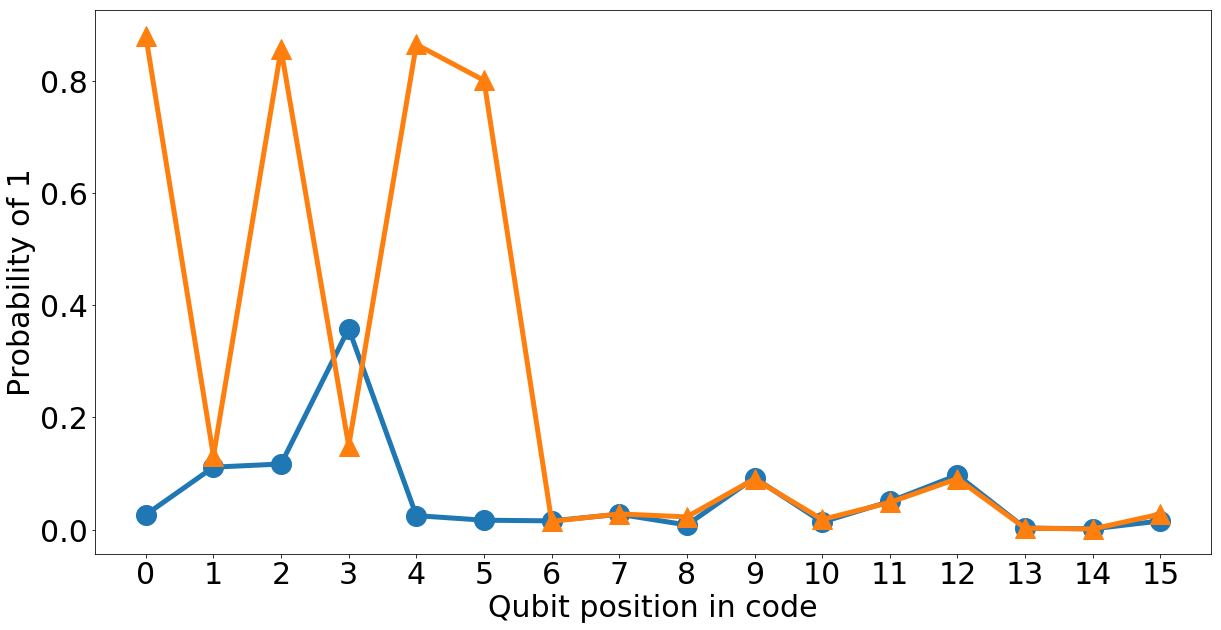



***Final state of each qubit for code of distance d = 4***


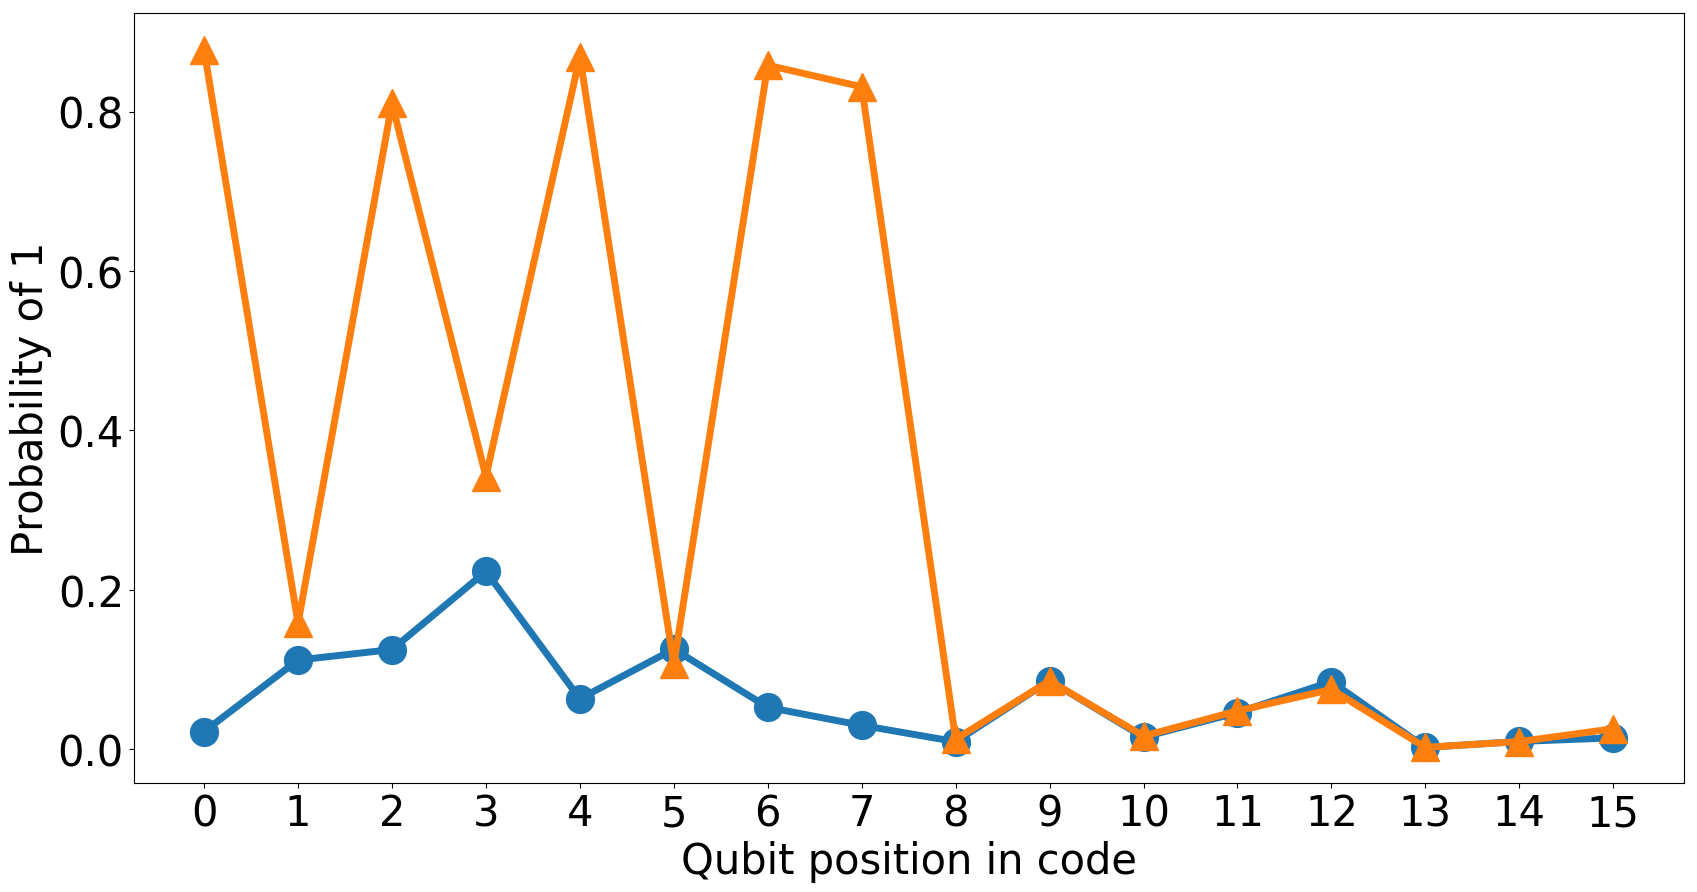



***Final state of each qubit for code of distance d = 5***


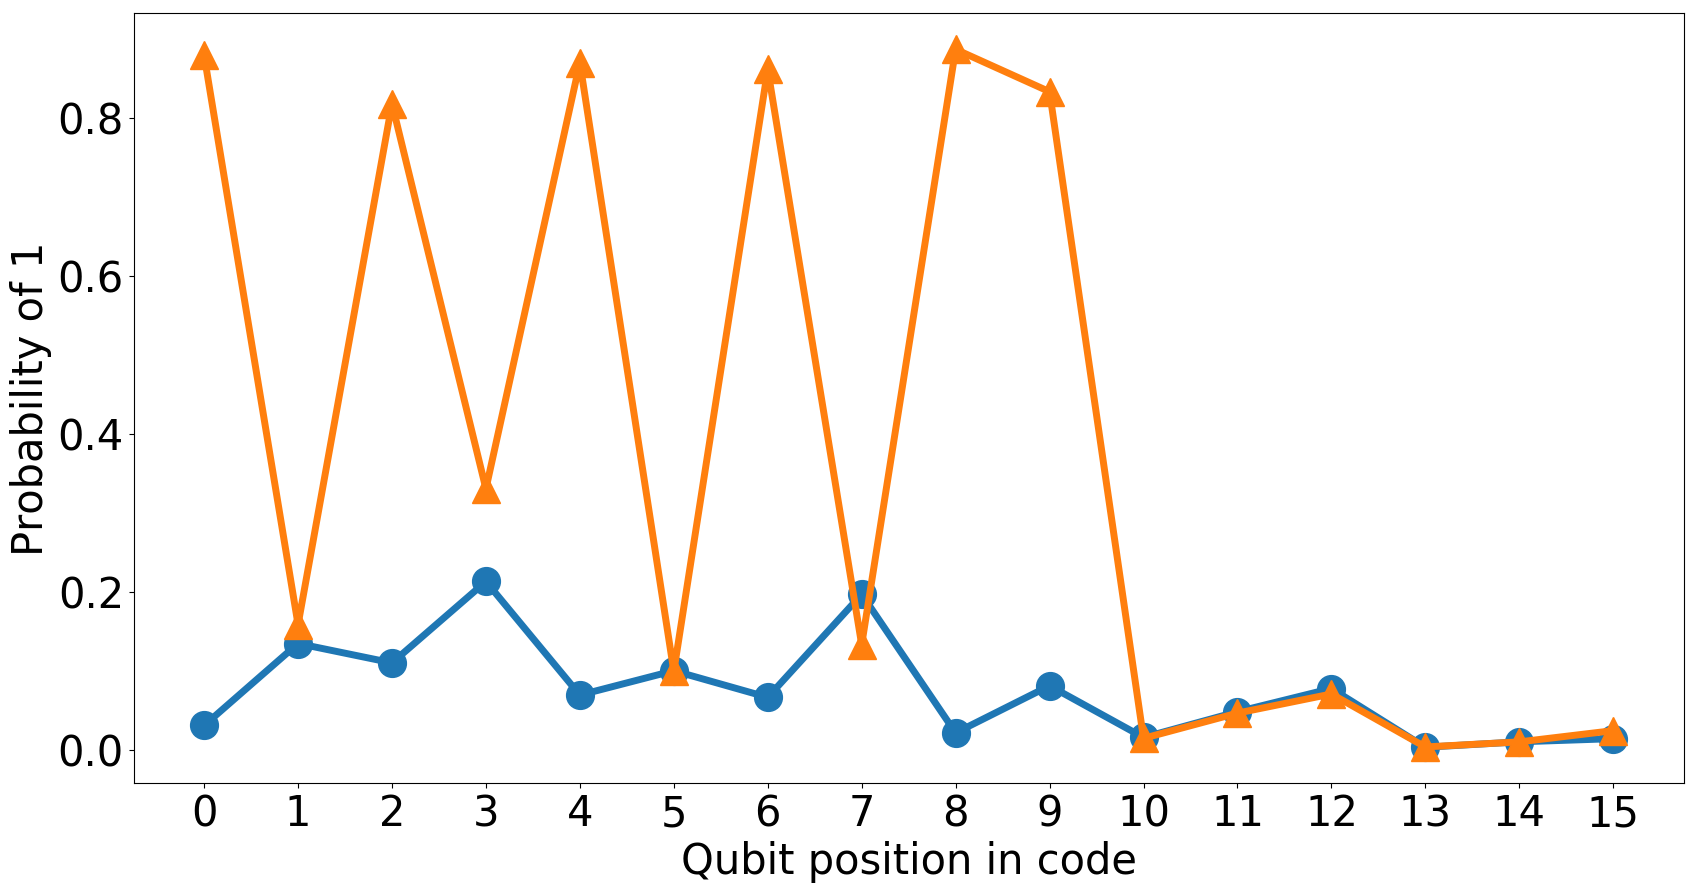



***Final state of each qubit for code of distance d = 6***


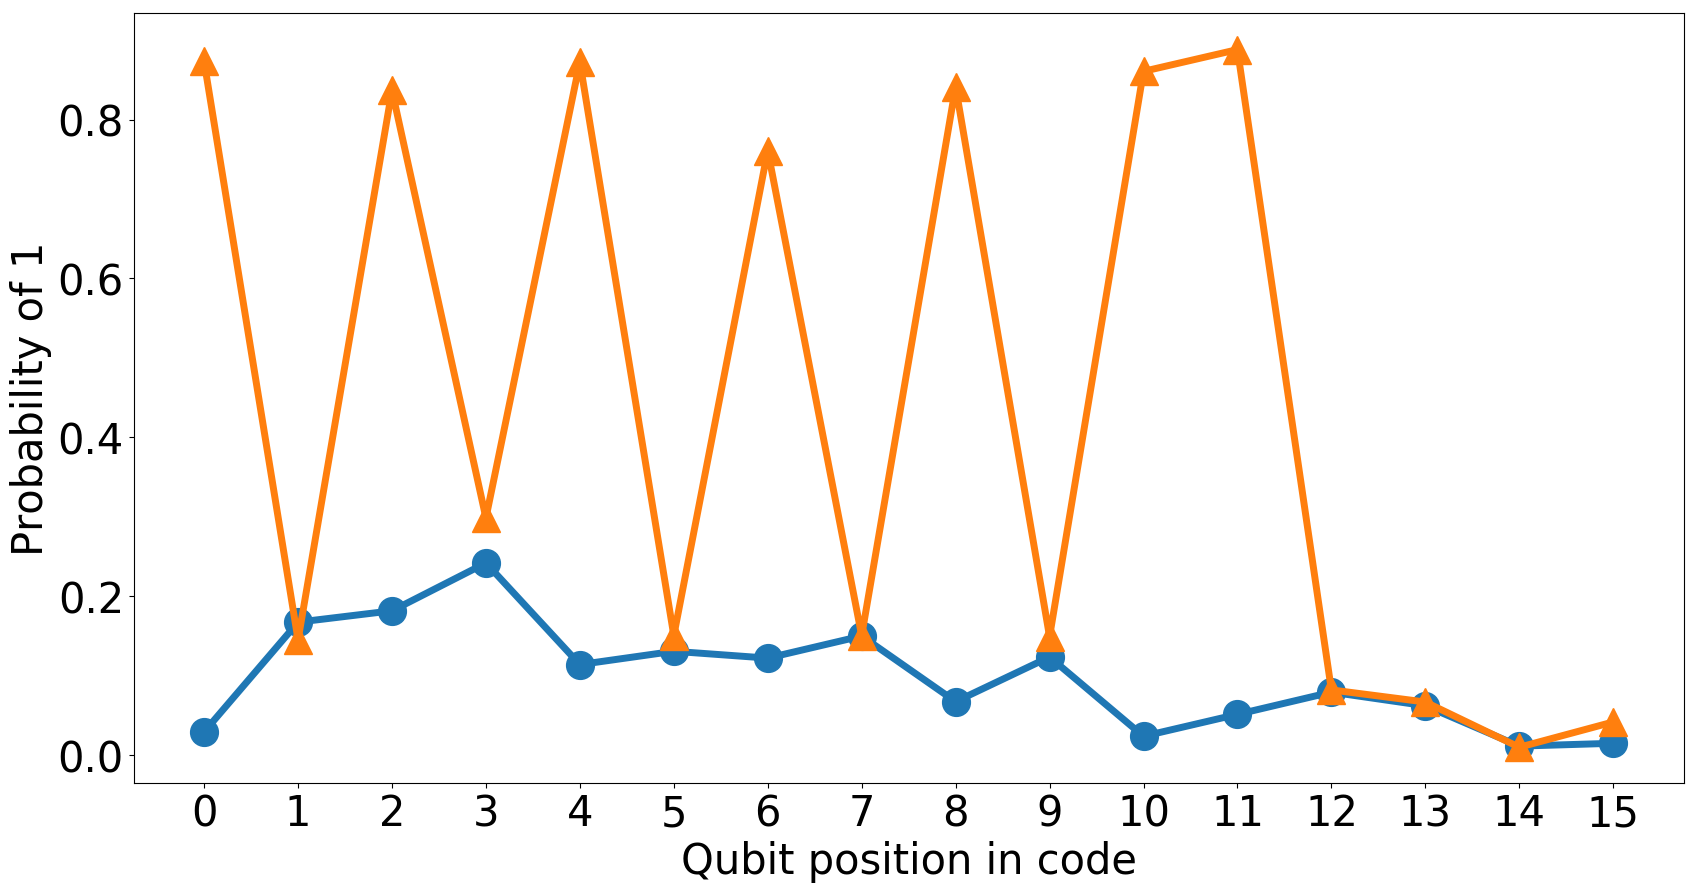



***Final state of each qubit for code of distance d = 7***


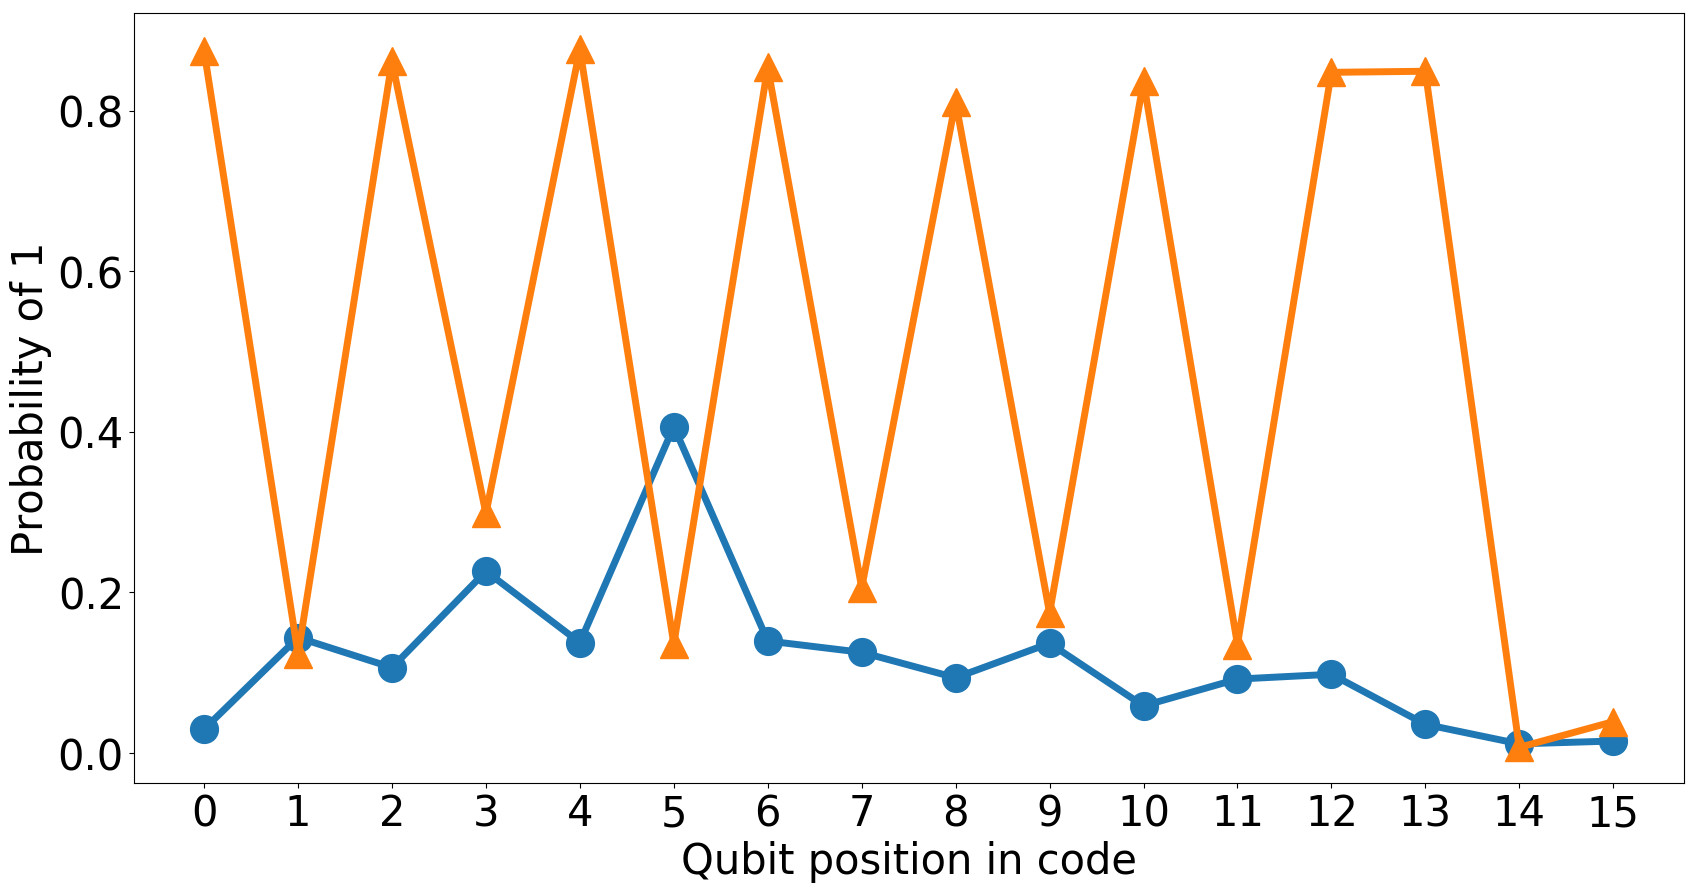



***Final state of each qubit for code of distance d = 8***


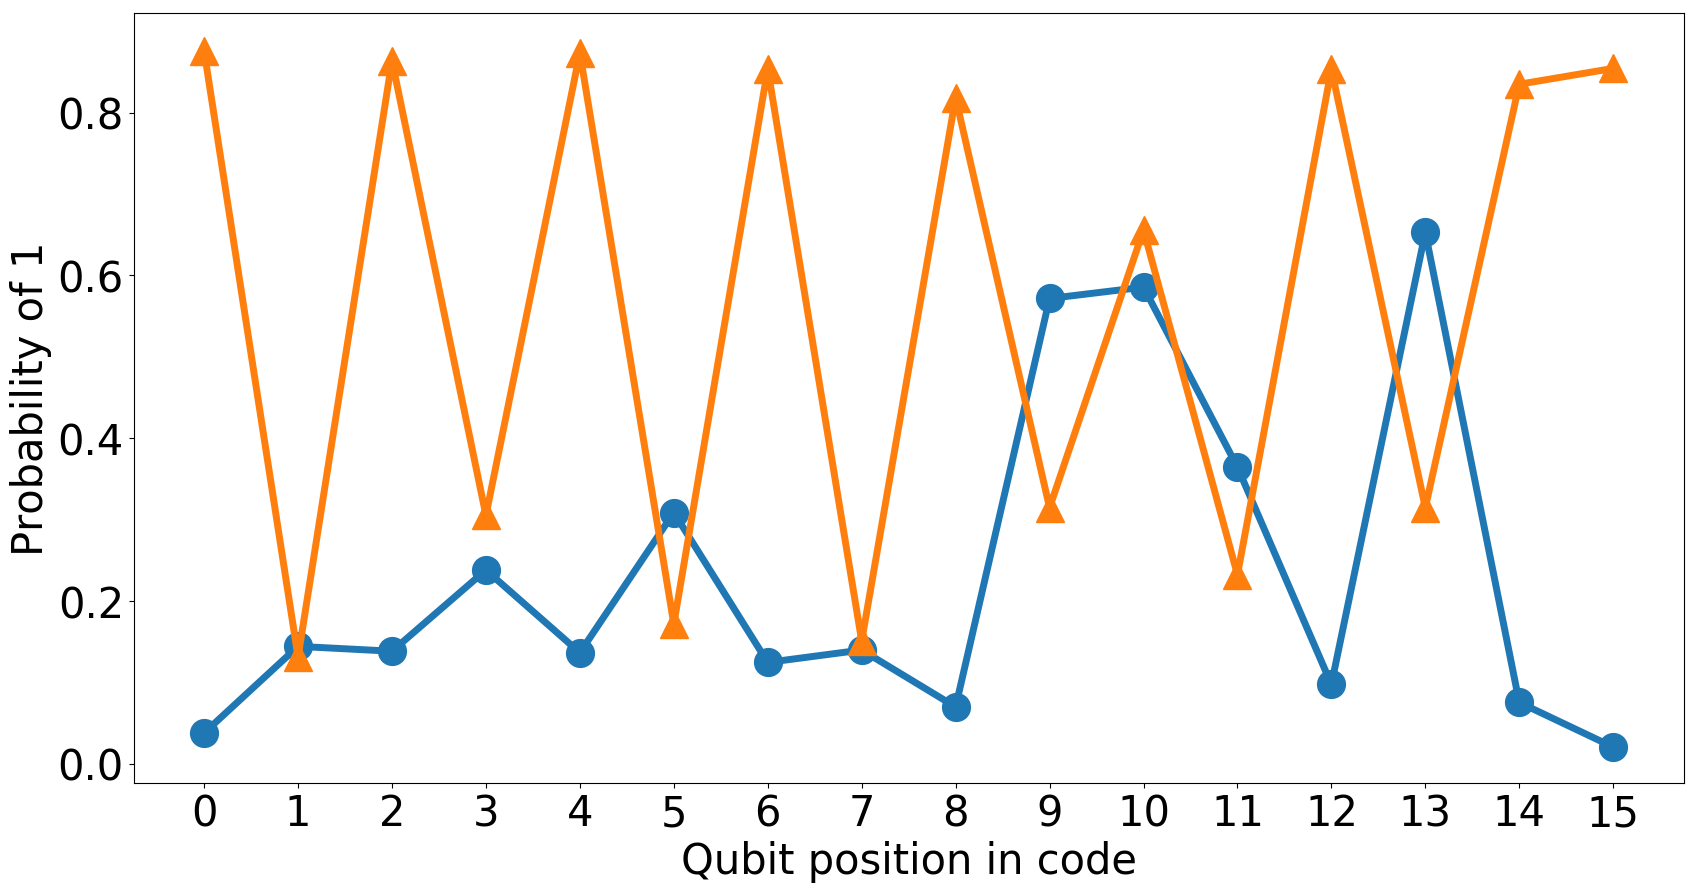

In [14]:
# plot for single qubit data for each code distance
for d in range(minSize,maxSize+1):
    X = range(16)
    Y = []
    y = []
    # a series for each encoded bit
    for encodedBit in range(2):        
        Y.append([singleResults[encodedBit][d-minSize][j][0] for j in range(16)])
        y.append([singleResults[encodedBit][d-minSize][j][1] for j in range(16)])
    # make graph
    print("\n\n***Final state of each qubit for code of distance d = " + str(d) + "***")
    MakeGraph(X,Y,y,['Qubit position in code','Probability of 1'])

### Logical error probabilities

The following two plots are for an encoded logical *0* and logical *1*, respectively. They show the probability of a logical error for codes of various sizes. The two series in each represent full decoding (using both code and ancilla qubits) and partial decoding (using only code qubits).

For comparison, the error probability for the single qubit memory is also shown. Plotting the inidividual values for the single qubit memory from each instance doesn't make a nice looking graph. So the minimum value of all these values is instead plotted across the whole graph.



***Encoded 0***

X values
range(3, 9)

Y values for Full decoding
[0.0113372802734375, 0.019500732421875, 0.007439384388623994, 0.005532978196879472, 0.003951419359530667, 0.0016711421476649255]

Error bars
[1.920154318213463e-06, 1.0207295417785645e-06, 9.157779016887233e-07, 7.479294369172796e-07, 4.6169339609114957e-07, 1.218175479321899e-07]


Y values for Partial decoding
[0.007781982421875, 0.0163726806640625, 0.008941650390625, 0.00757598876953125, 0.00554656982421875, 0.005645751953125]

Error bars
[6.17094337940216e-05, 0.00026884861290454865, 8.085370063781738e-05, 5.9707555919885635e-05, 3.11010517179966e-05, 3.243796527385712e-05]


Y values for Single qubit memory
[0.00994873046875, 0.00994873046875, 0.00994873046875, 0.00994873046875, 0.00994873046875, 0.00994873046875]

Error bars
[1.962273381650448e-05, 1.962273381650448e-05, 1.962273381650448e-05, 1.962273381650448e-05, 1.962273381650448e-05, 1.962273381650448e-05]



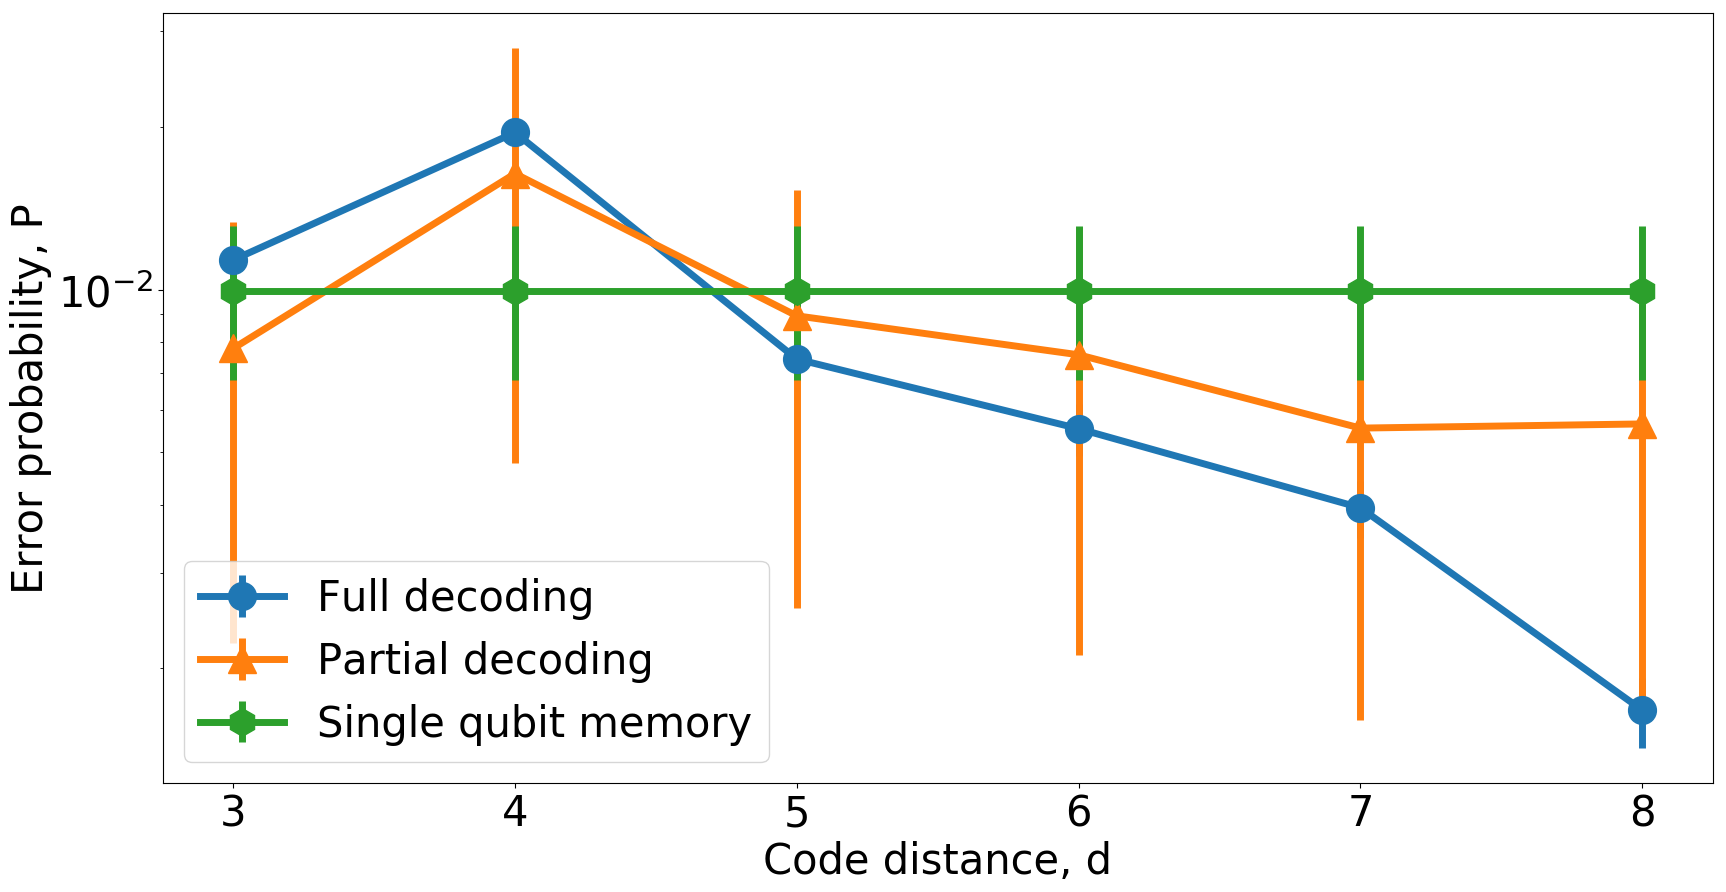



***Encoded 1***

X values
range(3, 9)

Y values for Full decoding
[0.039154052734375, 0.015533447265625, 0.007042967027540501, 0.007214248588492149, 0.00467154007833178, 0.0017272872801808437]

Error bars
[4.566274583339691e-06, 4.84660267829895e-06, 6.888137828332453e-07, 1.848013990340814e-06, 2.733381234288383e-07, 1.4919514430887263e-07]


Y values for Partial decoding
[0.047393798828125, 0.026885986328125, 0.0084075927734375, 0.00983428955078125, 0.007232666015625, 0.00714874267578125]

Error bars
[0.0022529475390911102, 0.0007272399961948395, 7.115863263607025e-05, 9.887712076306343e-05, 5.2891671657562256e-05, 5.13480044901371e-05]


Y values for Single qubit memory
[0.009735107421875, 0.009735107421875, 0.009735107421875, 0.009735107421875, 0.009735107421875, 0.009735107421875]

Error bars
[2.8816750273108482e-05, 2.8816750273108482e-05, 2.8816750273108482e-05, 2.8816750273108482e-05, 2.8816750273108482e-05, 2.8816750273108482e-05]



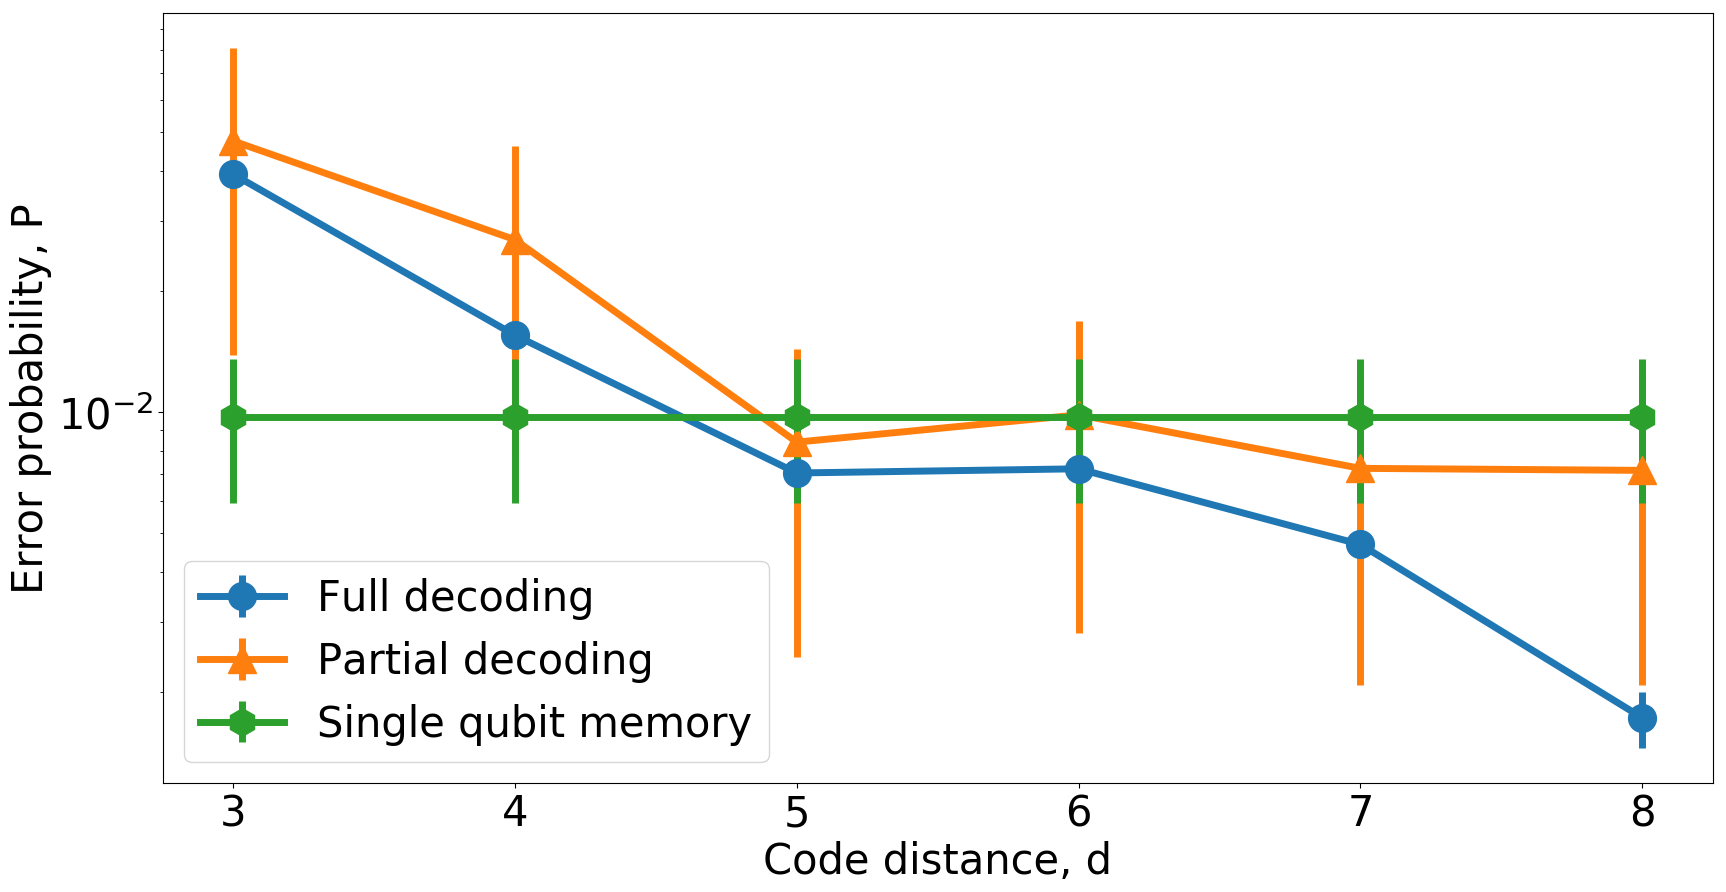

In [15]:
for encodedBit in range(2): # separate plots for each encoded bit
    X = range(minSize,maxSize+1)
    Y = []
    y = []
    for dec in range(2): # dec=0 corresponds to full decoding, and 1 to partial
        Y.append([codeResults[encodedBit][d-minSize][0][2*dec+0] for d in range(minSize,maxSize+1)])
        y.append([codeResults[encodedBit][d-minSize][0][2*dec+1] for d in range(minSize,maxSize+1)])
    # minimum error value for the single qubit memory is found and plotted as a comparsion (with max error bars)
    simulator = (device not in ['ibmqx3','ibmqx5'])
    minSingle = min([singleResults[encodedBit][d-minSize][GetAddress(d-1,1,simulator)][0] for d in range(minSize,maxSize+1)])
    maxSingle = max([singleResults[encodedBit][d-minSize][GetAddress(d-1,1,simulator)][1] for d in range(minSize,maxSize+1)])
    Y.append([minSingle]*(maxSize-minSize+1))
    y.append([maxSingle]*(maxSize-minSize+1))
    
    print("\n\n***Encoded " + str(encodedBit) + "***")
    MakeGraph(X,Y,y,['Code distance, d','Error probability, P'],
              labels=['Full decoding','Partial decoding','Single qubit memory'],legendPos='lower left',log=True,verbose=True)
     

### Truncated codes

The following four graphs show logical error probability plotted against effective code distance.

The series in each represent data from codes of different sizes. The rightmost data point for each is the logical error probability when the full code is used, and so the effective code distance is *d*. The point for effective code distance *d-1* is calculated from the same data, but with the final code and ancilla qubits ignored to effectively lower the code distance. The rest of the points are obtained by repeating this process.



***Encoded 0 with full decoding***


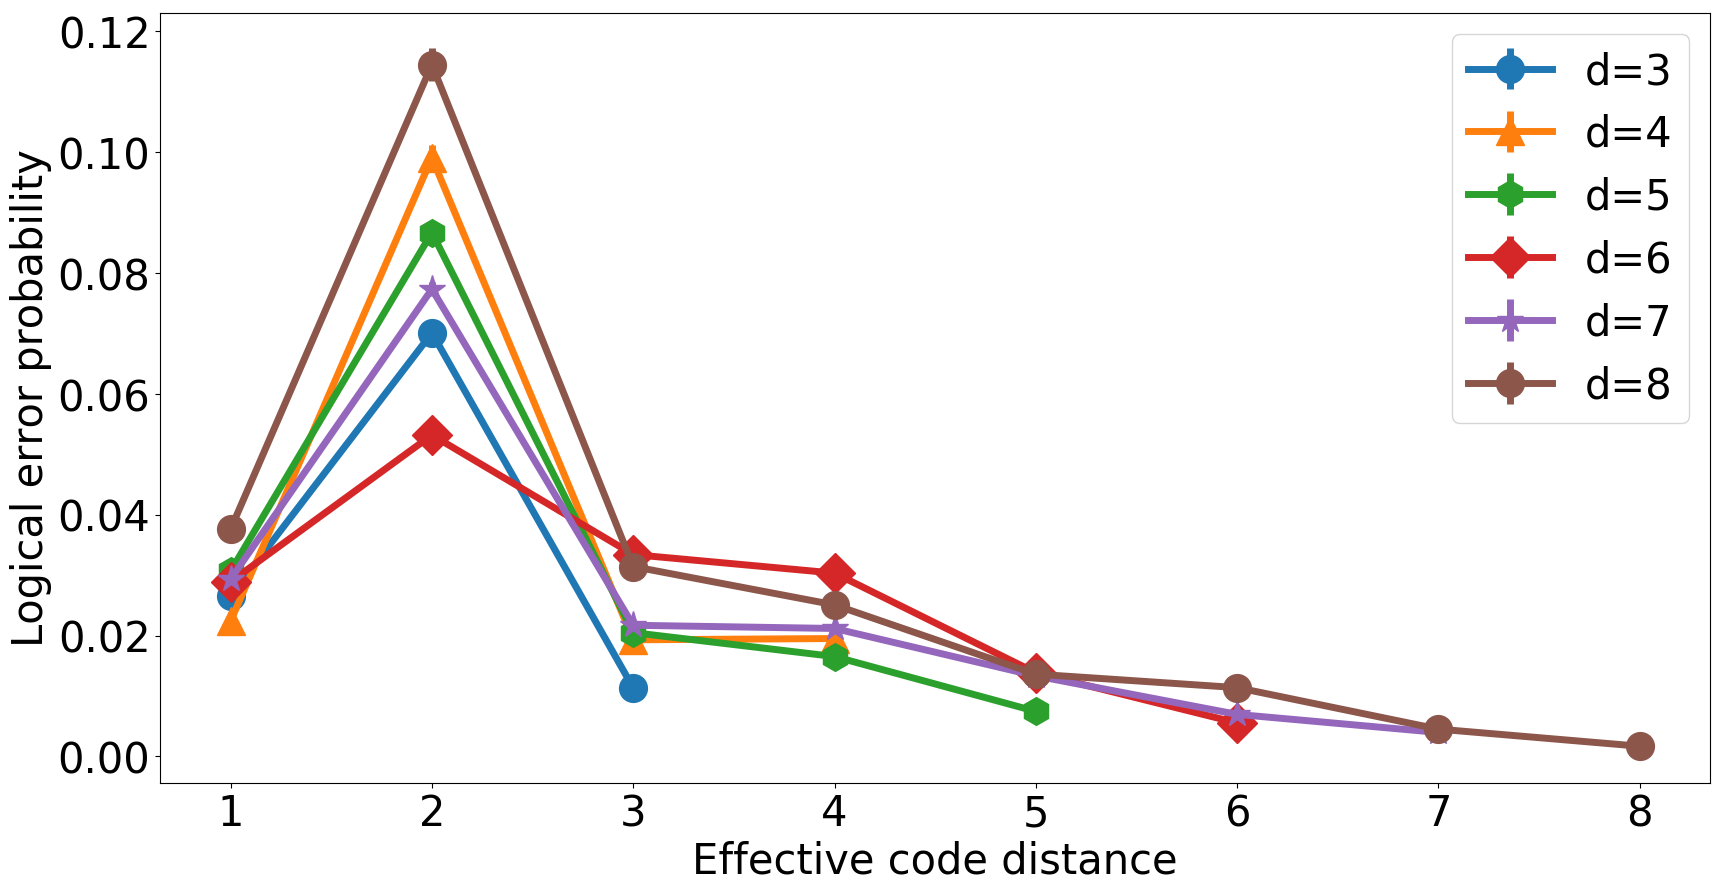



***Encoded 0 with partial decoding***


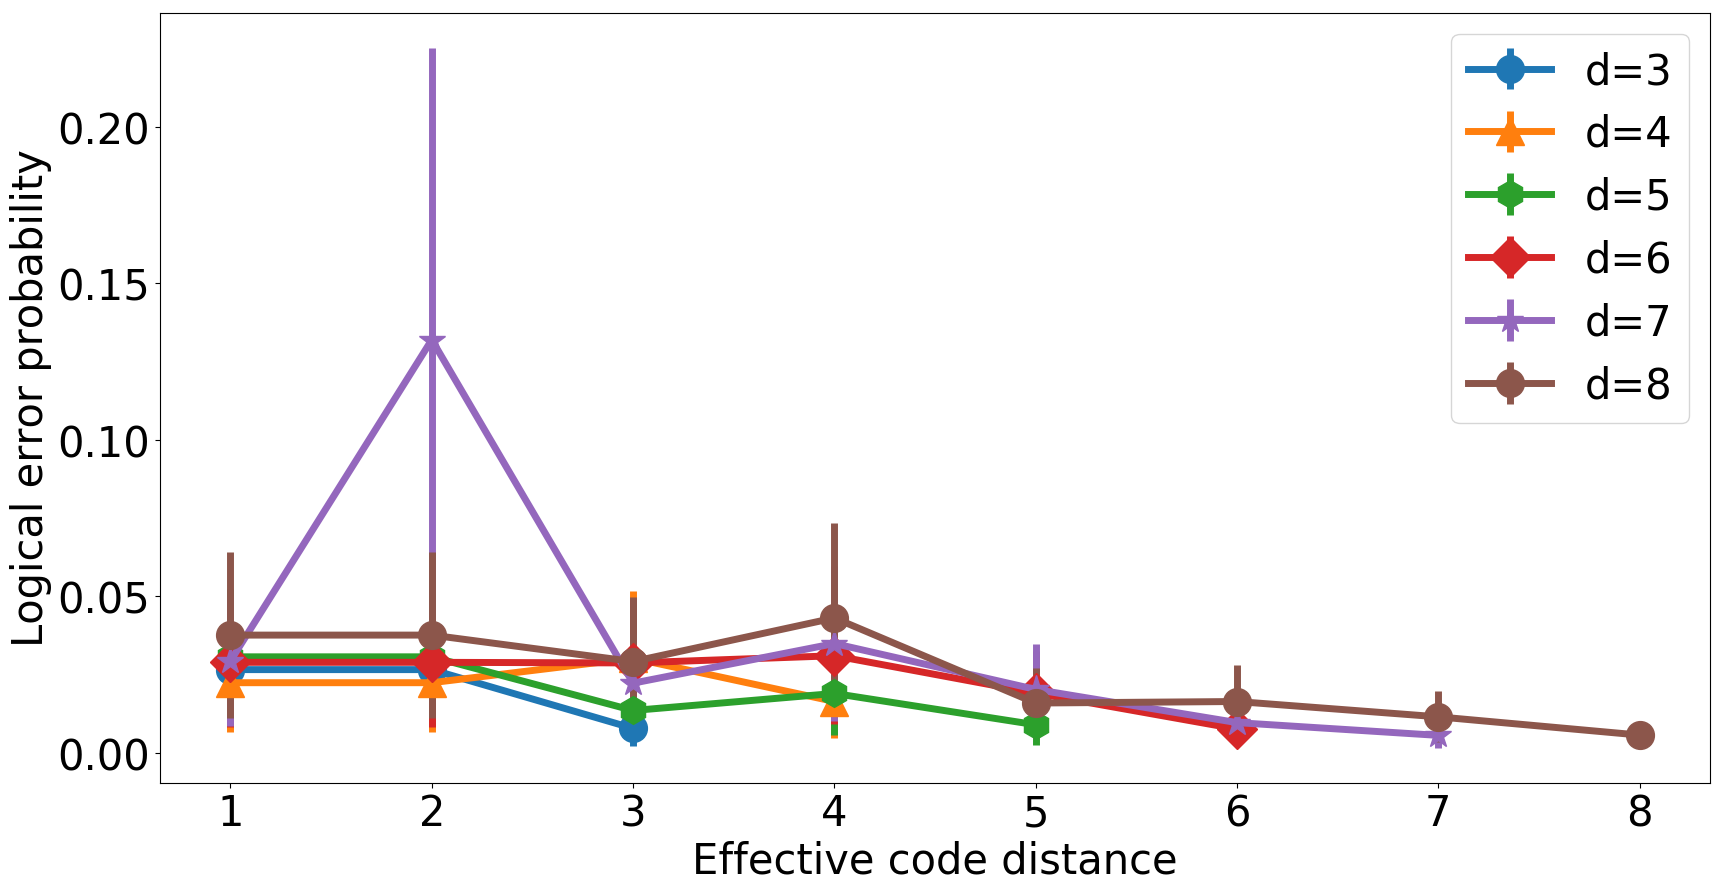



***Encoded 1 with full decoding***


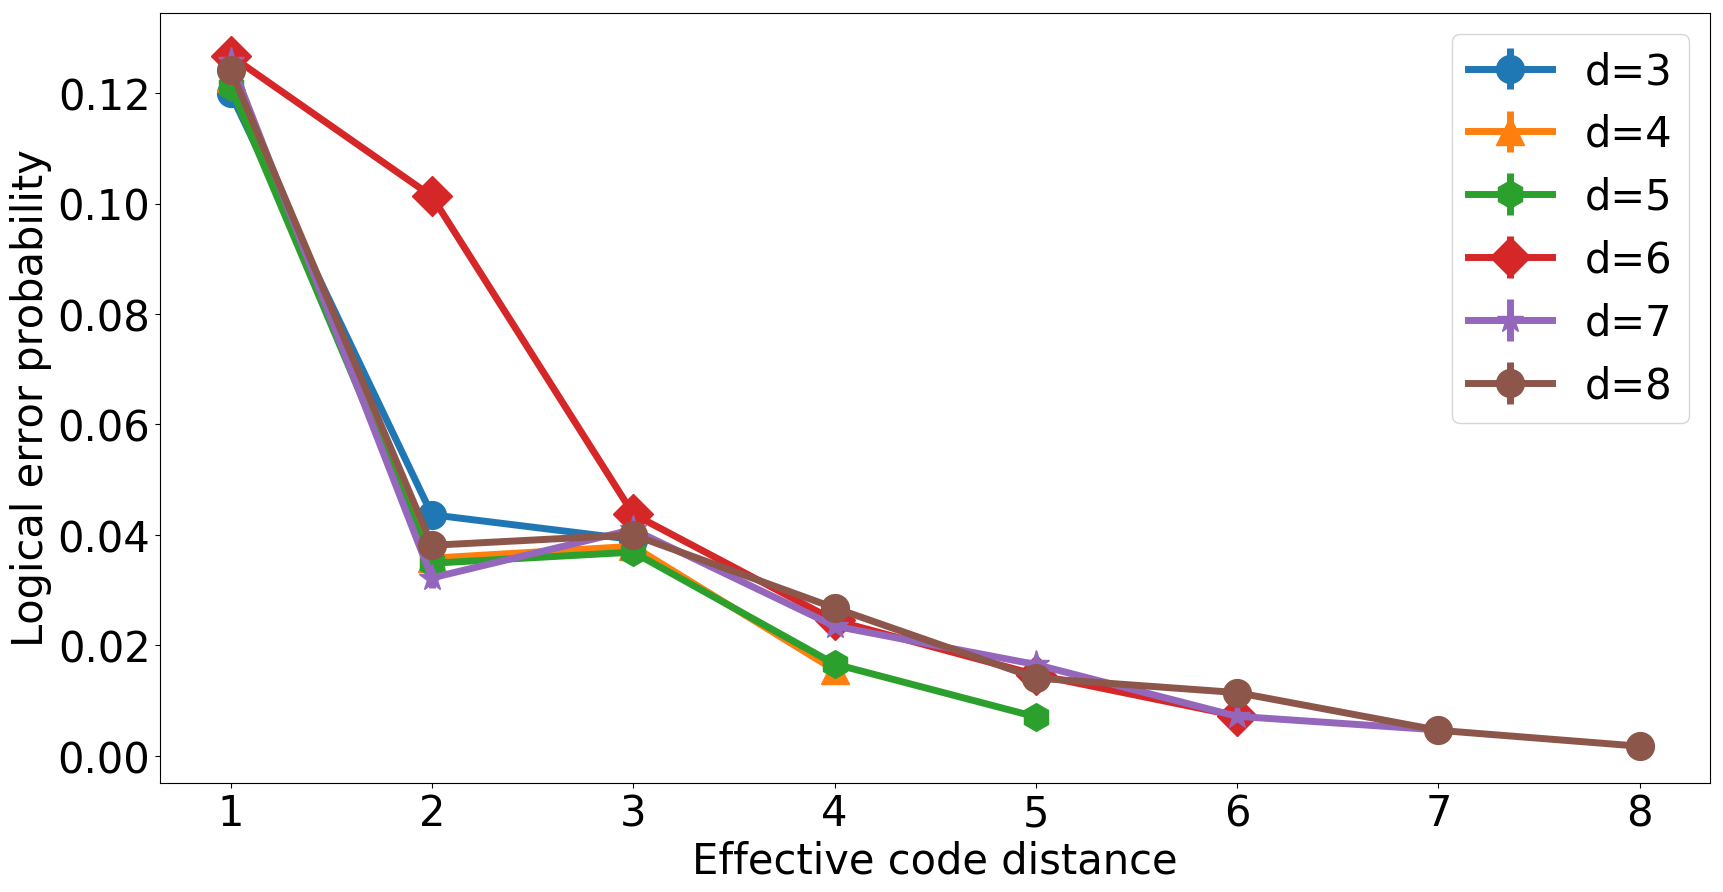



***Encoded 1 with partial decoding***


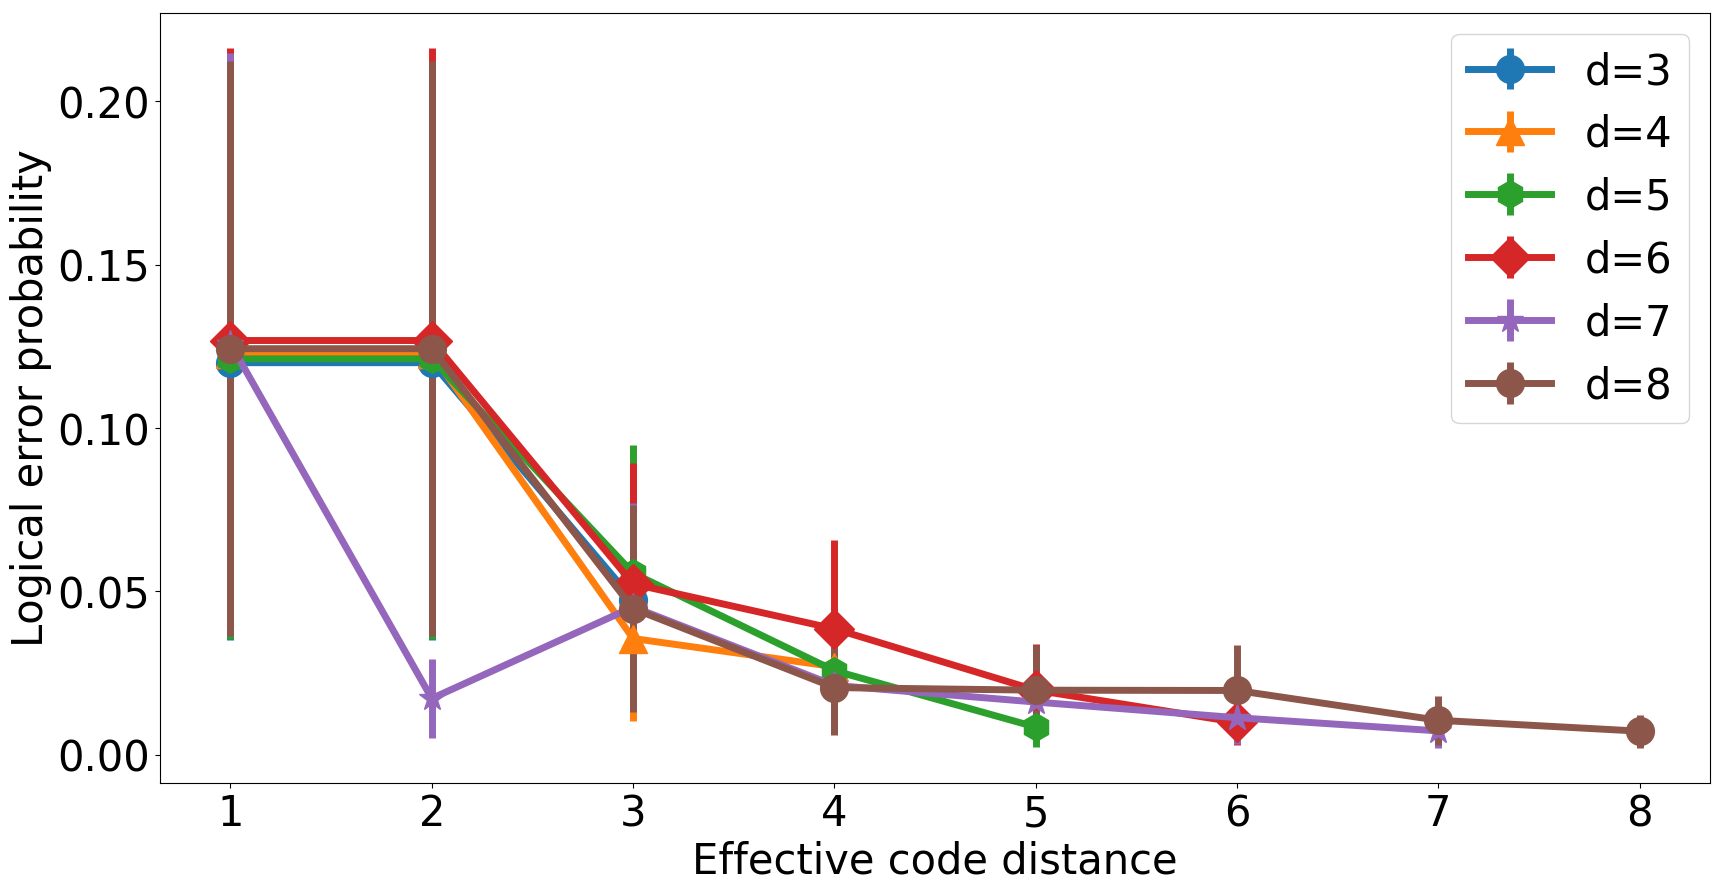

In [ ]:
for encodedBit in range(2): # separate plots for each encoded bit
    for decoding in ['full','partial']:
        dec = (decoding=='partial') # this is treated as 0 if full and 1 if partial
        X = range(1,maxSize+1)
        Y = []
        y = []
        labels = []
        for d in range(minSize,maxSize+1):# series for each code size
            seriesY = [math.nan]*(maxSize)
            seriesy = [math.nan]*(maxSize)
            for k in range(d):
                seriesY[d-k-1] = codeResults[encodedBit][d-minSize][k][2*dec+0]
                seriesy[d-k-1] = codeResults[encodedBit][d-minSize][k][2*dec+1]
            Y.append(seriesY)
            y.append(seriesy)
            labels.append('d='+str(d))
            
        print("\n\n***Encoded " + str(encodedBit) + " with " + dec*"partial" + (1-dec)*"full" + " decoding***")
        MakeGraph(X,Y,y,['Effective code distance','Logical error probability'],
                  labels=labels,legendPos = 'upper right')   

### Fit to exponential decay

We expect that the logical error probability will decay exponentially with $d$. To confirm this, we can just look at logarithmic plots and see if it goes down like a straight line. But it is better to do something a bit more mathematical, and get some numbers out to look at. So let's fit to an exponential decay.

#### Fitting the partial decoding data

The simplest fit we could do is to a curve of the form $A e^{-Bd}$: Just a standard exponential. Doing this would give us the numbers $A$ and $B$ that best fit the data, but they wouldn't directly tell us much about our code. This decay would also ignore the even/odd effects that we expect to see.

We therefore fit to the simplest model of errors on a repetition code. This concerns the case of partial decoding, and considered errors occuring independently on each qubit with a probability *p*. Logical errors are due to such events occuring on at least half of the qubits, and so the probability of a logical error is the total probability that such a configuration of qubit errors would occur.

To see that this decays exponentially with $d$, consider the minimum number of qubit errros required to cause a logical error,

$$ minErrors = \lceil d/2 \rceil $$

The most likely logical errors are those that occur due to exactly this number of qubit errors. This is because the probability for each specific configuration of such errors is higher than that for any other number of physical errors, and because the number of such configurations is also higher. The total probability for such an error configuration is

$$ {d \choose minErrors} \,\,\,\, p^{minErrors} \,\,\,\, (1-p)^{d-minErrors}$$

For odd $d$, we can use this as an approximation for the logical error rate. For even $d$, such a set of errors causes ambiguity in the decoding, and so there is a 50% chance that the correct decoding is still applied. Our approximation for the logical error rate will therefore be half of the above probability for even $d$. In both cases, the exponential decay due to the factor $p^{minErrors}$ will overwhelm the exponential increase from ${d \choose minErrors}$, leading to an exponential decay overall.

To study whether the decay of the real data, we will fit to the decay of logical error found for this simple model. Since $p$ is the only free parameter, it will be varied to find the best fit given mean square difference of the logarithms. The resulting value of $p$ can then give us some idea of the physical error rate of the qubits throughout the process.

#### Fitting the full decoding data

For the full decoding case, let us consider two extremal cases. Firstly, the case for which all CNOTs and ancilla qubits are perfect. Full decoding would then effectively factor into two rounds of error correction, each of which can be modelled as for partial decoding. We will refer to the values of the physical error probability for these rounds as $p_0$ and $p_1$, respectively. Clearly $p = p_0(1-p_1)+p_1(1-p_0)$, though we will use the approximation $p=p_0+p_1$ for simplicity.

The second extremal case is that for which the syndrome measurements result in no useful information being placed on the ancillas. This could either be due to the CNOTs being completely ineffective, or the ancillas being completely decohered. In this case the ancilla results can be ignored. Full decoding could then be treated as a single round of partial decoding.

We will therefore fit the data for full decoding to two rounds of the simple model. This will be done by assuming that one round has the error probability $p_0 = p$, found from the fit to the partial decoding data, and the other has no errors ($p_1=0)$. The fit will then optimize over all other possible $p_0$ and $p_1$ given the $p=p_0+p_1$ constraint.

The resulting $p_0$ and $p_1$ will then tell us to what degree we can factorize the error correction into two rounds. If one is found to dominiate, it would suggest that the effectiveness of the syndrome measurement approaches the worst case scenario.

A more even split would support the notion that the syndrome measurement round is indeed effective. However, it is not a complete proof. Similar results could occur if the CNOTs were ineffective, but suffered correlated noise. Full proof of effectiveness would therefore require a deeper understanding of the effects of noise in the system.

In [ ]:
def MakeModelTables (q,d):
    # outputs an array of two dictionaries for the lookup table for a simple model of a distance d code
    # q[0] is prob of 0->1 noise, and q[1] is prob of 1->0
    # no disinction is made between strings with the same number of errors
    # the prob for all are assigned to a single string, all with 0s on the left and 1s on the right
    
    modelResults = [{},{}]
    bit = ["0","1"]
    for encodedBit in range(2):
        for errors in range(d+1):
            if encodedBit==0:
                string = "0"*(d-errors)+"1"*errors
            else:
                string = "0"*errors+"1"*(d-errors)
            modelResults[encodedBit][string] = scipy.special.binom(d,errors) * q[encodedBit]**errors * (1-q[encodedBit])**(d-errors)
            
    return modelResults

def TotalLogical (p0,d,p1=0): # outputs total logical error prob for a single or two round code
    P0 = CalculateError( encodedBit, MakeModelTables([p0,p0],d)[0], MakeModelTables([p0,p0],d) )
    P1 = CalculateError( encodedBit, MakeModelTables([p0,p0],d)[1], MakeModelTables([p1,p1],d) )
    return P0*(1-P1) + P1*(1-P0)

for encodedBit in range(2): # separate plots for each encoded bit
    
    p = [0]*2 # here is where we'll put p_0 and p_1
    bar = [0]*2
    
    for dec in [1,0]: # dec=0 corresponds to full decoding, and 1 to partial
        
        # get the results we want to fit to
        realResults = [codeResults[encodedBit][d-minSize][0][2*dec] for d in range(minSize,maxSize+1)]
         
        # search possible values intul we find a minimum (assumed to be global)
        # first we do the partial decoding to get p (which is stored in p[0])
        # then the full decoding to get p[1]=p_1
        minimizing = True
        delta = 0.001
        q = delta
        diff =[math.inf,math.inf]
        while minimizing:
            
            q += delta # set new q
            diff[0] = diff[1] # copy diff value for last p
            
            # calculate diff for new q
            diff[1] = 0
            for d in range(minSize,maxSize+1):
                if dec==1:
                    Q = TotalLogical(q,d)
                else:
                    Q = TotalLogical(p[0]-q,d,p1=q)
                diff[1] += ( math.log( realResults[d-minSize] ) - math.log( Q ) )**2
            # see if a minimum has been found
            minimizing = ( diff[0]>diff[1] )
            
        # go back a step on p to get pSum
        p[1-dec] = q - delta
        
        # get diff per qubit
        bar[1-dec] = math.exp(math.sqrt( diff[0]/(maxSize-minSize+1) ))
    
    p[0] = p[0] - p[1] # put p_0 in p[0] (instead of p)
        
    print("\n\n***Encoded " + str(encodedBit) + "***\n" )
        
    for j in [0,1]:
        print("   p_"+str(j)+" = " + str(p[j]) + " with fit values typically differing by a factor of " + str(bar[j]) + "\n")

        
    plottedMinSize = max(4,minSize) # we won't print results for d=3 for clarity
    X = range(plottedMinSize,maxSize+1)
    Y = []
    y = []
    # original plots
    for dec in range(2): # dec=0 corresponds to full decoding, and 1 to partial
        # results from the device
        Y.append([codeResults[encodedBit][d-minSize][0][2*dec+0] for d in range(plottedMinSize,maxSize+1)])
        y.append([codeResults[encodedBit][d-minSize][0][2*dec+1] for d in range(plottedMinSize,maxSize+1)])
    # fit lines
    for dec in range(2):
        if dec==1:
            Y.append([TotalLogical(p[0]+p[1],d) for d in range(plottedMinSize,maxSize+1)])
        else:
            Y.append([TotalLogical(p[0],d,p1=p[1]) for d in range(plottedMinSize,maxSize+1)])
        y.append([0]*(maxSize-plottedMinSize+1))

    MakeGraph(X,Y,y,['Code distance, d','Error probability, P'],
              labels=['Full decoding','Partial decoding','Full decoding (model)','Partial decoding (model)'],legendPos='lower left',log=True)
     

### Lookup tables

The following graphs focus on the case of partial decoding. They look at the probabilities for different kinds of errors on the code qubits, as well as the way in in which the decoding is performed.

When doing this we will combine the data from all 10 runs, to get a single data set that is cleaner than all the others. This will mean a lack of error bars, but we know what kind of values these would give from previous plots.

In this analysis, we will use the fact that it is pretty much just the number of *0*s and *1*s in a result that is important, and not their placement. So we'll look at the probability for each number of *1*s.

We'll plot this in two ways for each code distance. First we'll plot the number probability for each number of errors. For example, *00000* would have no errors in the case that *0* was stored, but five if *1* was stored. We would expect to see the probability decrease with the number of errors for both stored *0* and stored *1*.

We will then plot the number of *1*s. For stored *0*, this corresponds to the number of errors, and so we would expect it to decrease. For stored *1* it is the opposite, since no *1*s is the case of maximum error. The probability should therefore increase for this data. There will therefore be a crossover point for the number of *1*s, which explictly tells us something about decoding. If the number of *1*s in a given result is below the crossover point, the most likely encoded value is *0*. Above the crossover point, the most likely value is *1*.

In [ ]:
# for each code distance and each encoded bit value, we'll create a list of the probabilities for each possible number of errors
# list is initialized with zeros
errorNum = [[[0]*(d+1) for d in range(minSize,maxSize+1)] for _ in range(2)]

for d in range(minSize,maxSize+1):
        for bit in range(2):
            # for each code distance and each encoded bit value we look at all possible result strings
            for string in combinedResultsCode[bit][d-minSize]:
                # count the number of errors in each string
                num = 0
                for j in range(d):
                    num += ( int( string[j] , 2 ) + bit )%2
                # add prob to corresponding number of errors
                errorNum[bit][d-minSize][num] += combinedResultsCode[bit][d-minSize][string]
        

        # the we make a graph for each, and print a title
        Y0 = [y if y>0 else math.nan for y in errorNum[0][d-minSize]]
        Y1 = [y if y>0 else math.nan for y in errorNum[1][d-minSize]]
        print("\n\n***Probability of errors on code qubits for d = " + str(d) + "***")
        MakeGraph(range(d+1),[Y0,Y1],[[0]*(d+1)]*2,['Number of code qubit errors','Probability (log base 10)'],
                  labels=['Encoded 0','Encoded 1'],legendPos='upper right',log=True)

        # actually, we make two graphs. This one plots the number of 1s rather than errors, and so the plot for encoded 1 is inverted
        # Y0 in this graph is as before
        Y1 = Y1[::-1] # but Y1 has its order inverted
        print("\n\n***Probability for number of 1s in code qubit result for d = " + str(d) + "***")
        MakeGraph(range(d+1),[Y0,Y1],[[0]*(d+1)]*2,['Number of 1s in code qubit result','Probability (log base 10)'],
                  labels=['Encoded 0','Encoded 1'],legendPos='center right',log=True)    

### Effect of delay

We will now look at the effect of adding in delay. No data for this was gathered for *ibmqx3*, and the simulator does not currently support this feature. The following will therefore concern data from *ibmqx5*. The graphs below show how logical error probabilities change with delay for a chosen code size.

In [ ]:
# determine the code size to be considered
userInput = input("For what code size you wish to look at the delay? (input 3, 4, 5, 6, 7 or 8) \n").upper()
if userInput in ['3','4','5','6','7','8']:
    size = int(userInput)
else:
    size = 8

In [ ]:
for encodedBit in range(2):

    Y_full = []
    y_full = []

    Y_partial = []
    y_partial = []

    Y_single = []
    y_single = []

    for delay in range(5):
                
        codeResults, singleResults, combinedResultsCode = ProcessData('ibmqx5',encodedBit,size,size,10,delay)

        Y_full.append( codeResults[0][0][0] )
        y_full.append( codeResults[0][0][1] )

        Y_partial.append( codeResults[0][0][2] )
        y_partial.append( codeResults[0][0][3] )

        Y_single.append( singleResults[0][GetAddress(size-1,1,False)][0] )
        y_single.append( singleResults[0][GetAddress(size-1,1,False)][1] )
        
    X = range(5)
    Y = [Y_full,Y_partial,Y_single]
    y = [y_full,y_partial,y_single]

    print("\n\n***Encoded " + str(encodedBit) + "***")
    MakeGraph(X,Y,y,['Delay time','Error probability, P'],
              labels=['Full decoding','Partial decoding','Single qubit memory'],legendPos='lower right')
     